In [68]:
import matplotlib.pyplot as plt
import os
import wfdb
import glob
import random
import warnings
import tempfile
import shutil
import seaborn as sns
import pandas as pd

from scipy.signal import butter, filtfilt

import numpy as np
from numpy import asarray

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization, LayerNormalization # type: ignore
from tensorflow.keras.activations import relu, sigmoid  # type: ignore
from tensorflow.keras.losses import MeanSquaredError  # type: ignore
from tensorflow.keras.metrics import MeanAbsoluteError  # type: ignore
from tensorflow.keras.metrics import MeanAbsolutePercentageError # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.metrics import BinaryAccuracy # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

FOLDER_PATH = '24h-emgcg/'
FOLDER_SAMPLE = '24h-ecg-sample/'
FOLDER_NORMALIZE = '24h-ecg-normalized/'
FOLDER_FILTER = '24h-ecg-normalized-filter/'
FOLDER_QC_MODEL = 'qc-model/'
FOLDER_QC_MODEL_TUNNING = 'qc_model_tuning/'
FOLDER_STROKE_MODEL_TUNNING = 'stroke_model_tuning/'
DATASET_QC = "dataset-qc-model/"
DATASET_QC_TEST = "dataset-qc-test/"
DATASET_STROKE = "24h-ecg-quality/"
DATASET_STROKE_UNQUALITY = "24h-ecg-unquality/"
MODEL = "model/"
PHYSIONET_PATH = 'cves/1.0.0/data/24h-electromyography'
PHYSIONET_DIR = 'cves'
LABEL_FILE = "label.txt"

Num GPUs Available:  0


# CONVERT TO p_signal FILES USING 2 CHANNEL ecg_0 vs ecg_1

In [48]:

record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]

records_missing_dat = []

records_exist = []

records_header_error = []

for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    if not os.path.exists(os.path.join(FOLDER_PATH, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  
    
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    if os.path.exists(output_file_path):
        records_exist.append(record_file)
        continue  
    
    try:
        record = wfdb.rdrecord(os.path.join(FOLDER_PATH, record_name), channels=[0, 1])
    except Exception as e:
        if isinstance(e, FileNotFoundError):
            records_missing_dat.append(record_name)
        else:
            print(f"Error processing {record_name}: {str(e)}")
            records_header_error.append(record_name)
        continue
    
    signals = record.p_signal
    
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed.")
if records_missing_dat:
    print("The following records were skipped due to missing .dat files:")
    print(records_missing_dat)
if records_header_error:
    print("The following records had header syntax errors:")
    print(records_header_error)
print(f"Number of records converted: {len(record_files) - len(records_missing_dat) - len(records_header_error)}")

Conversion completed.
Number of records converted: 0


# DELETE ALL .dat .hea .maker files

In [49]:
extensions = ['.dat', '.hea', '.marker']

def delete_files_if_txt_exists(folder_path):
    for ext in extensions:
        file_pattern = os.path.join(folder_path, f'*{ext}')
        files = glob.glob(file_pattern)
        for file_path in files:
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            txt_file_path = os.path.join(folder_path, f'{base_name}_p_signal.txt')
            if os.path.exists(txt_file_path):
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error: {file_path} - {e.strerror}")

delete_files_if_txt_exists(FOLDER_PATH)

# CONVERT SIGNAL FROM uV to mV 

In [50]:

for filename in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, filename)
    if os.path.isfile(file_path):
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as temp_file:
            with open(file_path, 'r') as file:
                for line in file:
                    values = line.split()
                    modified_values = [str(float(value)/1000) for value in values]
                    temp_file.write('\t'.join(modified_values) + '\n')

        shutil.copy(temp_file.name, file_path)
        os.remove(temp_file.name)

print("All files have been modified.")

KeyboardInterrupt: 

# Function get list of file names, plot data in range,...

In [ ]:

# List file names from folder name
def get_main_names_of_files(x):
    file_names = os.listdir(x)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

# PLOT SIGNAL IN RANGE(m , n) BY FILENAME
def plot_ecg_signal(main_name_of_file, folder_path, n, m=0):
    # start m end n
    file_path = os.path.join(folder_path, f'{main_name_of_file}_p_signal.txt')
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist.')
        return
    try:
        # Load the data with a maximum of n rows
        warnings.filterwarnings("ignore", message="Input line contained no data")
        total_data = np.loadtxt(file_path, max_rows=n)
        total_rows = total_data.shape[0]
        if m < 0 or n > total_rows or m >= n:
            raise ValueError(f"Invalid range: {m} to {n}. File contains {total_rows} rows.")
        data_segment = total_data[m:n, :]
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    time = np.arange(m, n) * 1  # 1 ms per sample
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, data_segment[:, 0])
    plt.title('Channel 1')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    plt.subplot(2, 1, 2)
    plt.plot(time, data_segment[:, 1])
    plt.title('Channel 2')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.tight_layout()
    plt.show()

def count_rows_in_file(prefix, directory):
    suffix = '_p_signal.txt'
    filename = prefix + suffix
    file_path = os.path.join(directory, filename)
    
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

names = get_main_names_of_files(FOLDER_PATH)

print("Main names of files:", names)
print(len(names))


Main names of files: ['s0322-07052204', 's0242-06012405', 's0184-05091311', 's0335-07040503', 's0231-05111709', 's0175-05030325', 's0376-07091805', 's0221-06082208', 's0208-05102508', 's0153-05021018', 's0225-06022111', 's0218-05110113', 's0351-07062105', 's0230-06013111', 's0197-05060906', 's0358-07071203', 's0358-07071204', 's0247-06050205', 's0376-07091804', 's0221-06082209', 's0208-05102509', 's0184-05091310', 's0239-06012607', 's0164-06033006', 's0157-05062311', 's0322-07052205', 's0231-05111708', 's0232-06060108', 's0204-05092907', 's0230-06013110', 's0351-07062104', 's0354-07051506', 's0187-05040711', 's0164-06033107', 's0218-05110112', 's0331-07031501', 's0210-05092012', 's0153-05021019', 's0030-04051907', 's0132-04102801', 's0207-05090814', 's0215-06030712', 's0305-06113004', 's0361-07080906', 's0166-05031008', 's0352-07060705', 's0305-06113003', 's0214-05110807', 's0352-07060702', 's0154-05050307', 's0160-04052807', 's0174-05062113', 's0336-07041701', 's0348-07052402', 's0221

# RAMDOMLY SAMPLE 100 NON-OVERLAPPING SEGMENTS EACH SIGNAL 

In [ ]:
sampling_rate = 1000  # Freq definition
segment_length_ms = 6000
segment_length_samples = int(sampling_rate * (segment_length_ms / 1000))

max_segments = 100

for filename in os.listdir(FOLDER_PATH):
    if filename.endswith('.txt') and 'p_signal' in filename:
        file_path = os.path.join(FOLDER_PATH, filename)
        output_base_filename = filename.replace('_p_signal.txt', '')

        with open(file_path, 'r') as file:
            data = file.readlines()

        # Maximum number of segments possible
        possible_segments = min(max_segments, len(data) // segment_length_samples)

        # Calculate start points for each segment
        start_indices = sorted(random.sample(range(0, len(data) - segment_length_samples + 1), possible_segments))

        for i, start in enumerate(start_indices):
            segment = data[start:start + int(segment_length_samples)]
            segment_filename = f"{output_base_filename}_{i + 1}_p_signal.txt"
            segment_file_path = os.path.join(FOLDER_SAMPLE, segment_filename)

            with open(segment_file_path, 'w') as outfile:
                outfile.writelines(segment)

        print(f"Processed {filename} into {possible_segments} segments.")

print("Sampling complete.")

Processed s0322-07052204_p_signal.txt into 100 segments.
Processed s0242-06012405_p_signal.txt into 100 segments.
Processed s0184-05091311_p_signal.txt into 100 segments.
Processed s0335-07040503_p_signal.txt into 100 segments.
Processed s0231-05111709_p_signal.txt into 100 segments.
Processed s0175-05030325_p_signal.txt into 100 segments.
Processed s0376-07091805_p_signal.txt into 100 segments.
Processed s0221-06082208_p_signal.txt into 2 segments.
Processed s0208-05102508_p_signal.txt into 100 segments.
Processed s0153-05021018_p_signal.txt into 100 segments.
Processed s0225-06022111_p_signal.txt into 100 segments.
Processed s0218-05110113_p_signal.txt into 100 segments.
Processed s0351-07062105_p_signal.txt into 100 segments.
Processed s0230-06013111_p_signal.txt into 100 segments.
Processed s0197-05060906_p_signal.txt into 100 segments.
Processed s0358-07071203_p_signal.txt into 100 segments.
Processed s0358-07071204_p_signal.txt into 100 segments.
Processed s0247-06050205_p_signal

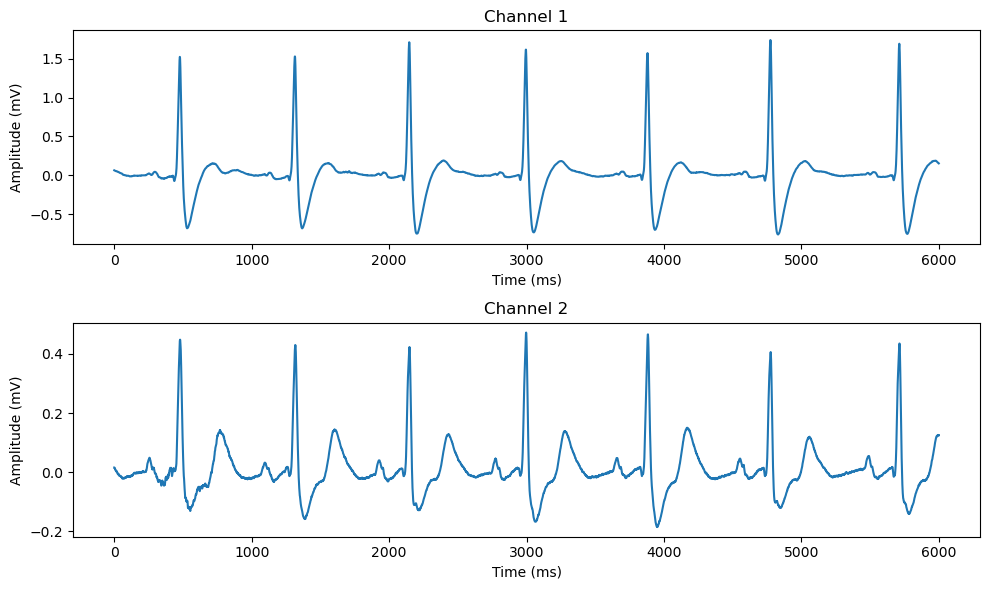

In [ ]:
# CHECK DATA BY PLOT SIGNAL

# plot_ecg_signal('s0402', FOLDER_SAMPLE, 40000, 34000)
plot_ecg_signal('s0402-08010704_1', FOLDER_SAMPLE, 6000)
# plot_ecg_signal('s0402-08010704', FOLDER_PATH, 50000000)

# Normalizing datas after sampling using MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

for filename in os.listdir(FOLDER_SAMPLE):
    if filename.endswith('.txt'):
        file_path = os.path.join(FOLDER_SAMPLE, filename)
        
        # Load the data from the file
        data = np.loadtxt(file_path)

        # Check if the data is in two columns or a single column
        if data.ndim == 1:
            # If it's a single column, reshape for the scaler
            data = data.reshape(-1, 1)

        # Apply the MinMaxScaler to the data
        normalized_data = scaler.fit_transform(data)
        
        dest_file_path = os.path.join(FOLDER_NORMALIZE, filename)
        np.savetxt(dest_file_path, normalized_data)

print("All files have been normalized.")

All files have been normalized.


# Smoothing datas after normalization by ButterWorth filter to folder FOLDER_FILTER

In [ ]:
def extract_columns(file_name):
    full_file_path = os.path.join(FOLDER_NORMALIZE, file_name)
    
    data = np.loadtxt(full_file_path)
    
    left = data[:, 0]
    return left

def compute(smooth):
    first_derivative = np.gradient(smooth, 10)
    second_derivative = np.gradient(first_derivative, 10)
    return first_derivative, second_derivative

# Function to apply the low-pass filter
def butterworth_filter(signal):
    cutoff_frequency = 11  # Cutoff frequency in Hz
    sampling_rate = 1000  # Sampling rate in Hz
    order = 2  # Order of the polynomial
    # divide by (0.5 * sampling_rate)
    # frequencies are often normalized by the Nyquist frequency
    # which is half the sampling rate. 
    # The Nyquist frequency is the highest frequency that can be effectively 
    # sampled without introducing aliasing according to the Nyquist-Shannon sampling theorem.
    b, a = butter(order, cutoff_frequency / (0.5 * sampling_rate), btype='low')
    return filtfilt(b, a, signal)

In [ ]:

for filename in os.listdir(FOLDER_NORMALIZE):
    if filename.endswith('p_signal.txt'):
        destination_file_path = os.path.join(FOLDER_FILTER, filename)
        
        data = extract_columns(filename)
        smoothed = butterworth_filter(data)
        hi_freq = data - smoothed
        first_der, second_der = compute(smoothed)
        
        # Write the smoothed data, high-frequency data, and derivatives to a new file
        with open(destination_file_path, 'w') as file:
            for i in range(len(data)):
                file.write(f"{data[i]}\t{smoothed[i]}\t{hi_freq[i]}\t{first_der[i]}\t{second_der[i]}\n")

print("Filtering complete.")

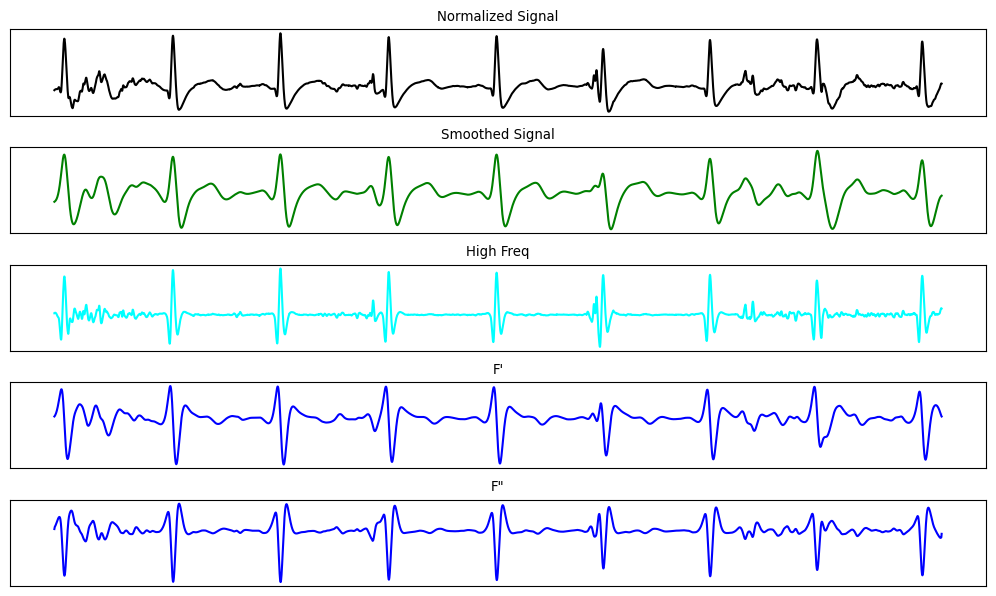

In [ ]:
def plotpp(filename):
    data = extract_columns(filename)
    smoothed = butterworth_filter(data)
    hi_freq = data - smoothed
    first_der, second_der = compute(smoothed)
    colors = ['black', 'green', 'cyan', 'blue', 'blue']

    plt.figure(figsize=(10, 6)) 
    plt.rcParams.update({'font.size': 8})

    plt.subplot(5, 1, 1)
    plt.plot(data, color=colors[0])
    plt.title('Normalized Signal')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 2)
    plt.plot(smoothed, color=colors[1])
    plt.title('Smoothed Signal')
    
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 3)
    plt.plot(hi_freq, color=colors[2])
    plt.title('High Freq')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 4)
    plt.plot(first_der, color=colors[3])
    plt.title('F\'')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 5)
    plt.plot(second_der, color=colors[4])
    plt.title('F\"')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.tight_layout()
    plt.show()

def plot_folder_file(folder, file_name):
    full_file_path = os.path.join(folder, file_name)
    
    data = np.loadtxt(full_file_path)
    
    raw = data[:, 0]
    smoothed = data[:, 1]
    hi_freq = data[:, 2]
    first_der = data[:, 3]
    second_der = data[:, 4]
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    plt.figure(figsize=(6, 6)) 
    plt.rcParams.update({'font.size': 8})

    plt.subplot(5, 1, 1)
    plt.plot(raw, color=colors[0])
    plt.title('Normalized Signal')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 2)
    plt.plot(smoothed, color=colors[1])
    plt.title('Smoothed Signal')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 3)
    plt.plot(hi_freq, color=colors[2])
    plt.title('High Freq')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 4)
    plt.plot(first_der, color=colors[3])
    plt.title('F\'')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplot(5, 1, 5)
    plt.plot(second_der, color=colors[4])
    plt.title('F\"')
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.tight_layout()
    plt.show()
    
plotpp('s0030-04051907_15_p_signal.txt')


# Clone randomly 4 segments each subject for training 
# 797 segments collected

In [ ]:
with open(os.path.join(DATASET_QC, LABEL_FILE), 'w') as label:
    for name in names:
        file = [file for file in os.listdir(FOLDER_FILTER) if file.startswith(name)]
        count_clone = min(4, len(file))  
        files_to_copy = random.sample(file, count_clone)
        for file_name in files_to_copy:
            source_file_path = os.path.join(FOLDER_FILTER, file_name)
            destination_file_path = os.path.join(DATASET_QC, file_name)
            shutil.copyfile(source_file_path, destination_file_path)
            label.write(f"{file_name} 1.0\n")

# Function for paging and manual label

In [ ]:
def label(file_name, folder):
    with open(os.path.join(folder, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 1.0", " 0.0")
            label_file.write(line)
        label_file.truncate()
        
def revert(file_name, folder):
    with open(os.path.join(folder, LABEL_FILE), 'r+') as label_file:
        lines = label_file.readlines()
        label_file.seek(0)
        for line in lines:
            if file_name in line:
                line = line.replace(" 0.0", " 1.0")
            label_file.write(line)
        label_file.truncate()
        
def paging(data, page, page_size):
  if page <= 0 or page_size <= 0:
    return [] 

  start_index = (page - 1) * page_size
  end_index = start_index + page_size

  if end_index > len(data):
    end_index = len(data)

  return data[start_index:end_index]

dataset = get_main_names_of_files(DATASET_QC)
dataset.sort()
print(dataset)

data = paging(dataset, 1, 2)
print(data)

['s0030-04051907_15', 's0030-04051907_36', 's0030-04051907_53', 's0030-04051907_78', 's0030-04051908_26', 's0030-04051908_30', 's0030-04051908_35', 's0030-04051908_7', 's0044-05062806_26', 's0044-05062806_29', 's0044-05062806_35', 's0044-05062806_46', 's0044-05062807_13', 's0044-05062807_33', 's0044-05062807_56', 's0044-05062807_74', 's0064-05081805_15', 's0064-05081805_40', 's0064-05081805_89', 's0064-05081805_97', 's0064-05081806_26', 's0064-05081806_73', 's0064-05081806_88', 's0064-05081806_91', 's0067-05040508_34', 's0067-05040508_57', 's0067-05040508_64', 's0067-05040508_95', 's0067-05040509_2', 's0067-05040509_3', 's0067-05040509_6', 's0067-05040509_7', 's0067-05040510_25', 's0067-05040510_35', 's0067-05040510_50', 's0067-05040510_59', 's0067-05040511_47', 's0067-05040511_48', 's0067-05040511_82', 's0067-05040511_97', 's0068-05022417_100', 's0068-05022417_17', 's0068-05022417_18', 's0068-05022417_82', 's0068-05022418_15', 's0068-05022418_70', 's0068-05022418_82', 's0068-05022418_

# Get list signal by pagination and grid plot

s0172-05071906_51_p_signal.txt
s0277-06090703_96_p_signal.txt
s0352-07060703_27_p_signal.txt
s0221-06082206_3_p_signal.txt
s0331-07031504_36_p_signal.txt
s0321-07022206_90_p_signal.txt
s0335-07040503_7_p_signal.txt
s0352-07060703_20_p_signal.txt
s0239-06012607_63_p_signal.txt
s0210-05092012_12_p_signal.txt
s0371-07091105_94_p_signal.txt
s0044-05062806_35_p_signal.txt
s0221-06082206_4_p_signal.txt
s0363-07072604_51_p_signal.txt
s0184-05091310_56_p_signal.txt
s0378-07100403_1_p_signal.txt
s0321-07022206_97_p_signal.txt
s0218-05110113_94_p_signal.txt
s0340-07050204_51_p_signal.txt
s0248-06041808_17_p_signal.txt
s0334-07040303_42_p_signal.txt
s0153-05021019_5_p_signal.txt
s0160-04052807_76_p_signal.txt
s0331-07031503_13_p_signal.txt


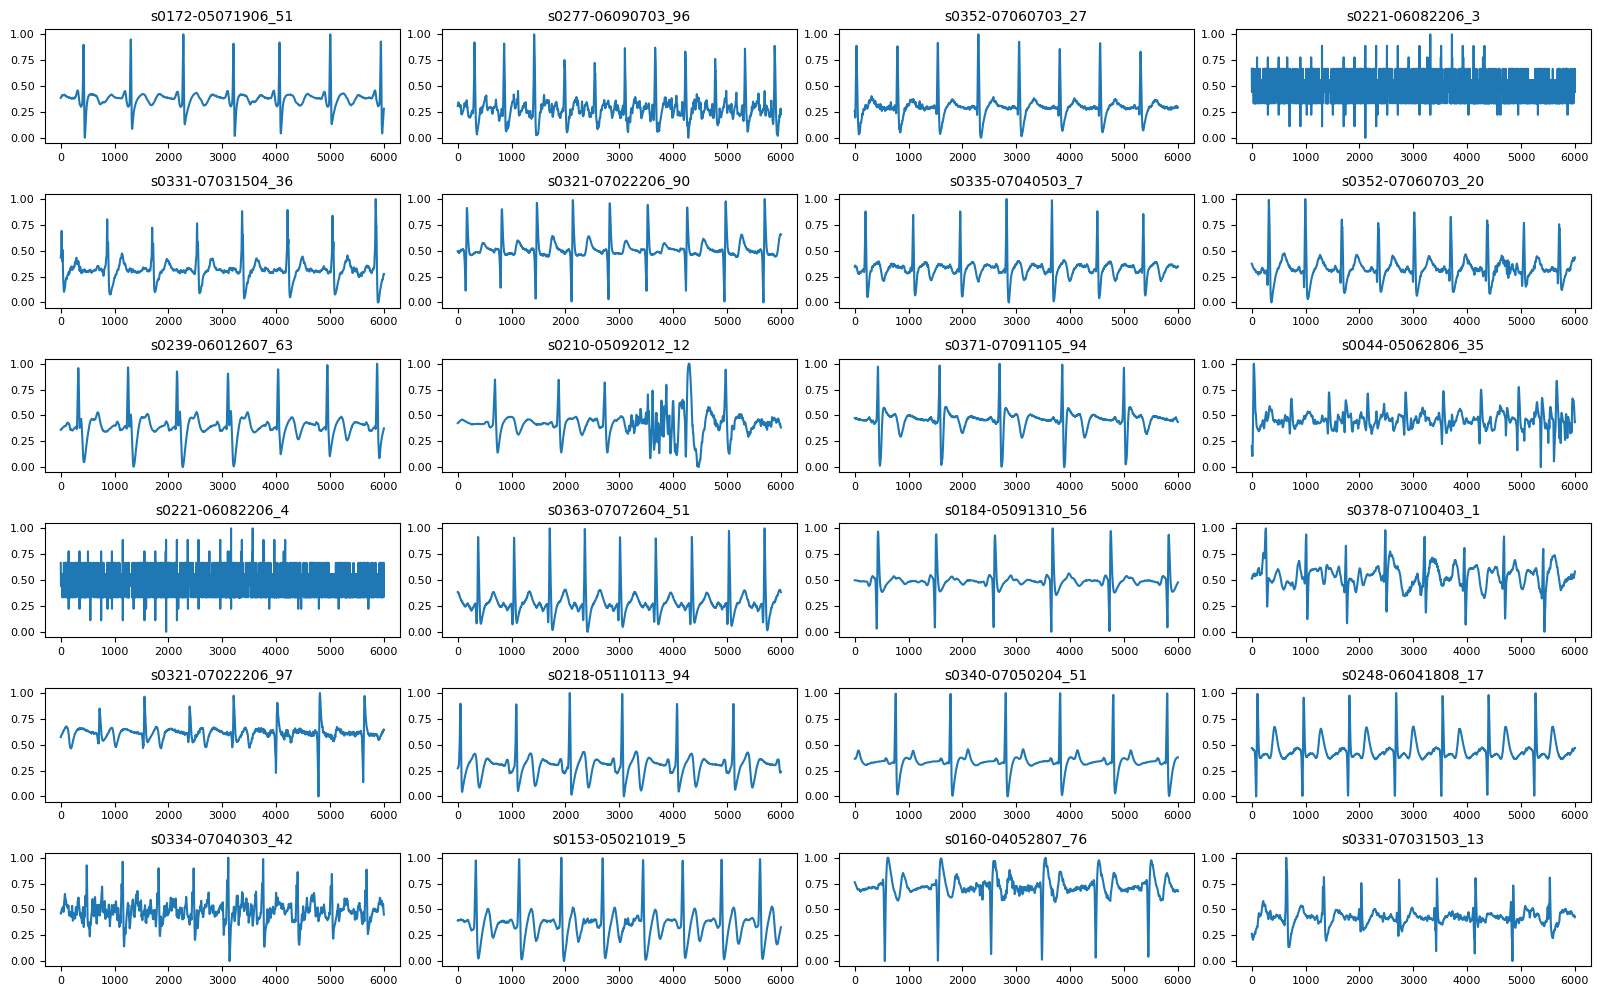

In [ ]:
def grid_plot(folder, page, pageSize = 24, num_cols = 4):
    dataset = get_main_names_of_files(folder)
    file_names = paging(dataset, page, pageSize)

    num_plots = len(file_names)
    num_cols = num_cols
    num_rows = int(np.ceil(num_plots / num_cols))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 10))

    for i, file_name in enumerate(file_names):
        print(f'{file_name}_p_signal.txt')
        title = file_name
        file_name = os.path.join(folder, f'{file_name}_p_signal.txt')
        
        row = i // num_cols
        col = i % num_cols
        data = np.loadtxt(file_name) 
        data = data[:,0]
        axs[row, col].plot(data)
        axs[row, col].set_title(title, size=10)
        
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

grid_plot(DATASET_QC, 1, 24, 4)

# Check data drawn and call method label manually

In [ ]:
label('s0030-04051907_53_p_signal.txt', DATASET_QC)
label('s0044-05062806_26_p_signal.txt', DATASET_QC)
label('s0044-05062806_35_p_signal.txt', DATASET_QC)
label('s0064-05081805_40_p_signal.txt', DATASET_QC)
label('s0064-05081805_89_p_signal.txt', DATASET_QC)
label('s0064-05081806_88_p_signal.txt', DATASET_QC)
label('s0322-07052205_73_p_signal.txt', DATASET_QC)
label('s0322-07052205_78_p_signal.txt', DATASET_QC)
label('s0324-07030105_36_p_signal.txt', DATASET_QC)
label('s0354-07051506_51_p_signal.txt', DATASET_QC)
label('s0324-07030105_37_p_signal.txt', DATASET_QC)
label('s0334-07040303_42_p_signal.txt', DATASET_QC)
label('s0334-07040304_91_p_signal.txt', DATASET_QC)
label('s0336-07041701_11_p_signal.txt', DATASET_QC)
label('s0331-07031504_33_p_signal.txt', DATASET_QC)
label('s0336-07041701_12_p_signal.txt', DATASET_QC)
label('s0343-07080704_66_p_signal.txt', DATASET_QC)
label('s0348-07052403_33_p_signal.txt', DATASET_QC)
label('s0351-07062105_91_p_signal.txt', DATASET_QC)
label('s0343-07080704_54_p_signal.txt', DATASET_QC)
label('s0353-07060504_18_p_signal.txt', DATASET_QC)
label('s0352-07060702_12_p_signal.txt', DATASET_QC)
label('s0067-05040510_25_p_signal.txt', DATASET_QC)
label('s0067-05040510_35_p_signal.txt', DATASET_QC)
label('s0067-05040510_50_p_signal.txt', DATASET_QC)
label('s0067-05040510_59_p_signal.txt', DATASET_QC)
label('s0068-05022417_100_p_signal.tx', DATASET_QC)
label('s0068-05022417_18_p_signal.txt', DATASET_QC)
label('s0068-05022417_82_p_signal.txt', DATASET_QC)
label('s0068-05022418_15_p_signal.txt', DATASET_QC)
label('s0068-05022418_82_p_signal.txt', DATASET_QC)
label('s0121-04042801_71_p_signal.txt', DATASET_QC)
label('s0132-04102802_72_p_signal.txt', DATASET_QC)
label('s0153-05021018_100_p_signal.tx', DATASET_QC)
label('s0153-05021018_41_p_signal.txt', DATASET_QC)
label('s0154-05050307_72_p_signal.txt', DATASET_QC)
label('s0160-04052807_76_p_signal.txt', DATASET_QC)
label('s0160-04052808_13_p_signal.txt', DATASET_QC)
label('s0163-04060411_47_p_signal.txt', DATASET_QC)
label('s0163-04060411_49_p_signal.txt', DATASET_QC)
label('s0164-06033004_90_p_signal.txt', DATASET_QC)
label('s0164-06033107_75_p_signal.txt', DATASET_QC)
label('s0164-06033107_99_p_signal.txt', DATASET_QC)
label('s0165-05092209_95_p_signal.txt', DATASET_QC)
label('s0166-05031008_46_p_signal.txt', DATASET_QC)
label('s0166-05031009_29_p_signal.txt', DATASET_QC)
label('s0166-05031009_41_p_signal.txt', DATASET_QC)
label('s0174-05062111_37_p_signal.txt', DATASET_QC)
label('s0174-05062111_76_p_signal.txt', DATASET_QC)
label('s0174-05062111_93_p_signal.txt', DATASET_QC)
label('s0176-04060217_87_p_signal.txt', DATASET_QC)
label('s0178-05041205_86_p_signal.txt', DATASET_QC)
label('s0184-05091310_82_p_signal.txt', DATASET_QC)
label('s0184-05091311_13_p_signal.txt', DATASET_QC)
label('s0194-05071408_65_p_signal.txt', DATASET_QC)
label('s0197-05060905_16_p_signal.txt', DATASET_QC)
label('s0197-05060905_21_p_signal.txt', DATASET_QC)
label('s0199-05041912_97_p_signal.txt', DATASET_QC)
label('s0199-05041913_37_p_signal.txt', DATASET_QC)
label('s0207-05090822_10_p_signal.txt', DATASET_QC)
label('s0210-05092012_12_p_signal.txt', DATASET_QC)
label('s0212-05111011_22_p_signal.txt', DATASET_QC)
label('s0213-05092707_64_p_signal.txt', DATASET_QC)
label('s0218-05110112_58_p_signal.txt', DATASET_QC)
label('s0322-07052204_21_p_signal.txt', DATASET_QC)
label('s0322-07052204_22_p_signal.txt', DATASET_QC)
label('s0322-07052204_31_p_signal.txt', DATASET_QC)
label('s0322-07052204_54_p_signal.txt', DATASET_QC)
label('s0322-07052205_20_p_signal.txt', DATASET_QC)
label('s0364-07072403_83_p_signal.txt', DATASET_QC)
label('s0221-06082210_74_p_signal.txt', DATASET_QC)
label('s0221-06082210_75_p_signal.txt', DATASET_QC)
label('s0221-06082209_96_p_signal.txt', DATASET_QC)
label('s0227-06020209_85_p_signal.txt', DATASET_QC)
label('s0230-06013110_22_p_signal.txt', DATASET_QC)
label('s0230-06013110_52_p_signal.txt', DATASET_QC)
label('s0230-06013110_91_p_signal.txt', DATASET_QC)
label('s0230-06013111_40_p_signal.txt', DATASET_QC)
label('s0230-06013111_43_p_signal.txt', DATASET_QC)
label('s0230-06013111_72_p_signal.txt', DATASET_QC)
label('s0230-06013111_84_p_signal.txt', DATASET_QC)
label('s0231-05111708_52_p_signal.txt', DATASET_QC)
label('s0231-05111708_90_p_signal.txt', DATASET_QC)
label('s0239-06012608_18_p_signal.txt', DATASET_QC)
label('s0240-06030215_14_p_signal.txt', DATASET_QC)
label('s0240-06030216_59_p_signal.txt', DATASET_QC)
label('s0374-07092706_44_p_signal.txt', DATASET_QC)
label('s0376-07091804_78_p_signal.txt', DATASET_QC)
label('s0380-07100203_90_p_signal.txt', DATASET_QC)
label('s0399-07120404_90_p_signal.txt', DATASET_QC)
label('s0248-06041807_10_p_signal.txt', DATASET_QC)
label('s0248-06041807_15_p_signal.txt', DATASET_QC)
label('s0248-06041807_30_p_signal.txt', DATASET_QC)
label('s0248-06041808_16_p_signal.txt', DATASET_QC)
label('s0277-06090703_21_p_signal.txt', DATASET_QC)
label('s0305-06113003_74_p_signal.txt', DATASET_QC)
label('s0321-07022201_12_p_signal.txt', DATASET_QC)
label('s0176-04060217_3_p_signal.txt', DATASET_QC)
label('s0207-05090822_9_p_signal.txt', DATASET_QC)
label('s0176-04060217_3_p_signal.txt', DATASET_QC)
label('s0221-06082202_1_p_signal.txt', DATASET_QC)
label('s0221-06082203_1_p_signal.txt', DATASET_QC)
label('s0221-06082204_1_p_signal.txt', DATASET_QC)
label('s0221-06082205_1_p_signal.txt', DATASET_QC)
label('s0221-06082205_2_p_signal.txt', DATASET_QC)
label('s0221-06082205_3_p_signal.txt', DATASET_QC)
label('s0221-06082206_2_p_signal.txt', DATASET_QC)
label('s0221-06082206_3_p_signal.txt', DATASET_QC)
label('s0221-06082206_4_p_signal.txt', DATASET_QC)
label('s0221-06082206_5_p_signal.txt', DATASET_QC)
label('s0225-06022111_4_p_signal.txt', DATASET_QC)
label('s0230-06013110_5_p_signal.txt', DATASET_QC)
label('s0247-06050206_1_p_signal.txt', DATASET_QC)
label('s0247-06050206_2_p_signal.txt', DATASET_QC)
label('s0247-06050206_3_p_signal.txt', DATASET_QC)
label('s0247-06050206_4_p_signal.txt', DATASET_QC)
label('s0321-07022201_5_p_signal.txt', DATASET_QC)
label('s0321-07022202_4_p_signal.txt', DATASET_QC)
label('s0321-07022202_6_p_signal.txt', DATASET_QC)
label('s0322-07052205_7_p_signal.txt', DATASET_QC)
label('s0331-07031502_1_p_signal.txt', DATASET_QC)
label('s0331-07031502_2_p_signal.txt', DATASET_QC)
label('s0331-07031502_6_p_signal.txt', DATASET_QC)
label('s0331-07031502_8_p_signal.txt', DATASET_QC)
label('s0336-07041701_2_p_signal.txt', DATASET_QC)
label('s0336-07041701_6_p_signal.txt', DATASET_QC)
label('s0337-07032903_1_p_signal.txt', DATASET_QC)
label('s0337-07032903_2_p_signal.txt', DATASET_QC)
label('s0337-07032903_3_p_signal.txt', DATASET_QC)
label('s0352-07060702_2_p_signal.txt', DATASET_QC)
label('s0352-07060702_3_p_signal.txt', DATASET_QC)
label('s0352-07060702_5_p_signal.txt', DATASET_QC)
label('s0067-05040509_2_p_signal.txt', DATASET_QC)
label('s0067-05040509_3_p_signal.txt', DATASET_QC)
label('s0067-05040509_6_p_signal.txt', DATASET_QC)
label('s0067-05040509_7_p_signal.txt', DATASET_QC)
label('s0353-07060503_8_p_signal.txt', DATASET_QC)
label('s0353-07060504_2_p_signal.txt', DATASET_QC)
label('s0363-07072604_6_p_signal.txt', DATASET_QC)
label('s0371-07091104_8_p_signal.txt', DATASET_QC)

# 131 low-quality segments; 666 high-quality segments; 1 label file .txt

# Build QC Model for check quality segment using for Stroke model

In [ ]:
def load_data(dataset_path, label_file):
    X = []
    y = []
    with open(os.path.join(dataset_path, label_file), 'r') as file:
        for line in file:
            file_name, label = line.split()
            label = float(label)
            with open(os.path.join(dataset_path, file_name), 'r') as signal_file:
                signal = np.loadtxt(signal_file)
            X.append(signal)
            y.append(int(label))
    return np.array(X), np.array(y)

X, y = load_data(DATASET_QC, LABEL_FILE)
print(X.shape, y.shape) 

(797, 6000, 5) (797,)


In [91]:
checkpoint_path = os.path.join(MODEL + FOLDER_QC_MODEL_TUNNING, "qc_checkpoint.keras")
model_path = os.path.join(MODEL + FOLDER_QC_MODEL_TUNNING, "qc_model.keras")

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    
if os.path.exists(model_path):
    os.remove(model_path)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

input_dim = (6000, 5)
epochs = 100
batch_size = 32

def qc_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('num_filters', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Int('kernel_size', min_value=3, max_value=30, step=3),
                     strides=hp.Int('stride', min_value=1, max_value=10, step=1),
                     activation='relu',
                     input_shape=input_dim))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.05)))
    # model.add(Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'))
    # model.add(Dropout(hp.Float('dropout_rate_dense', min_value=0.2, max_value=0.7, step=0.05)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    return model

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

tuner = kt.Hyperband(
    qc_model,
    objective='binary_accuracy',
    max_epochs=100,
    factor=3,
    directory=MODEL,
    project_name='qc_model_tuning'
)

tuner.search(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val), batch_size = batch_size, callbacks = callbacks)

qc_tuning_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
score = qc_tuning_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Save the best model
qc_tuning_model.save(model_path)


Reloading Tuner from model/qc_model_tuning/tuner0.json


/Users/macad/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/Users/macad/anaconda3/lib/python3.11/site-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/Users/macad/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', 

Test loss: 0.35633155703544617
Test accuracy: 0.856249988079071


In [92]:
tuning_mapping = tuner.get_best_hyperparameters(num_trials=1)[0]

kernel_size = tuning_mapping.get('kernel_size')
stride = tuning_mapping.get('stride')
num_filters = tuning_mapping.get('num_filters')
dropout_rate = tuning_mapping.get('dropout_rate')
learning_rate = tuning_mapping.get('learning_rate')

print(f"num_filters {num_filters}")
print(f"kernel_size {kernel_size}")
print(f"stride {stride}")
print(f"dropout_rate {dropout_rate}")
print(f"learning_rate {learning_rate}")

num_filters 128
kernel_size 30
stride 2
dropout_rate 0.30000000000000004
learning_rate 0.0009014460075099421


# Tunning hyperparameter manually 

In [93]:
checkpoint_path = os.path.join(MODEL, FOLDER_QC_MODEL + "qc_checkpoint.keras")
model_path = os.path.join(MODEL, FOLDER_QC_MODEL + "qc_model.keras")

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    
if os.path.exists(model_path):
    os.remove(model_path)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

input_dim = (6000, 5)
# kernel_size = 20
# stride = 10
# num_filters = 32
# dropout_rate = 0.5
# learning_rate = 0.001

def qc_model():
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, strides=stride, activation='relu', input_shape=input_dim))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    
    return model

# Model checkpoints
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

qc_manual_model = qc_model()

# Train the model
history = qc_manual_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

# Save the trained model
qc_manual_model.save(model_path)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - binary_accuracy: 0.7450 - loss: 0.5643
Epoch 1: val_loss improved from inf to 0.34870, saving model to model/qc-model/qc_checkpoint.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - binary_accuracy: 0.7485 - loss: 0.5597 - val_binary_accuracy: 0.8828 - val_loss: 0.3487 - learning_rate: 9.0145e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - binary_accuracy: 0.8084 - loss: 0.4943
Epoch 2: val_loss did not improve from 0.34870
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - binary_accuracy: 0.8091 - loss: 0.4923 - val_binary_accuracy: 0.8828 - val_loss: 0.3603 - learning_rate: 9.0145e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - binary_accuracy: 0.8287 - loss: 0.4214
Epoch 3: val_loss improved from 0.34870 to 0.34646, saving model to model/qc-model/qc_checkpoint.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - binary_accuracy: 0.8282 - loss: 0.4223 - val_binary_accuracy: 0.8828 - val_loss: 0.3465 - learning_rate: 9.0

# Tracking validation and training loss

tuning
Test loss: 35.63%
Test accuracy: 85.62%
manual
Test loss: 36.23%
Test accuracy: 86.87%


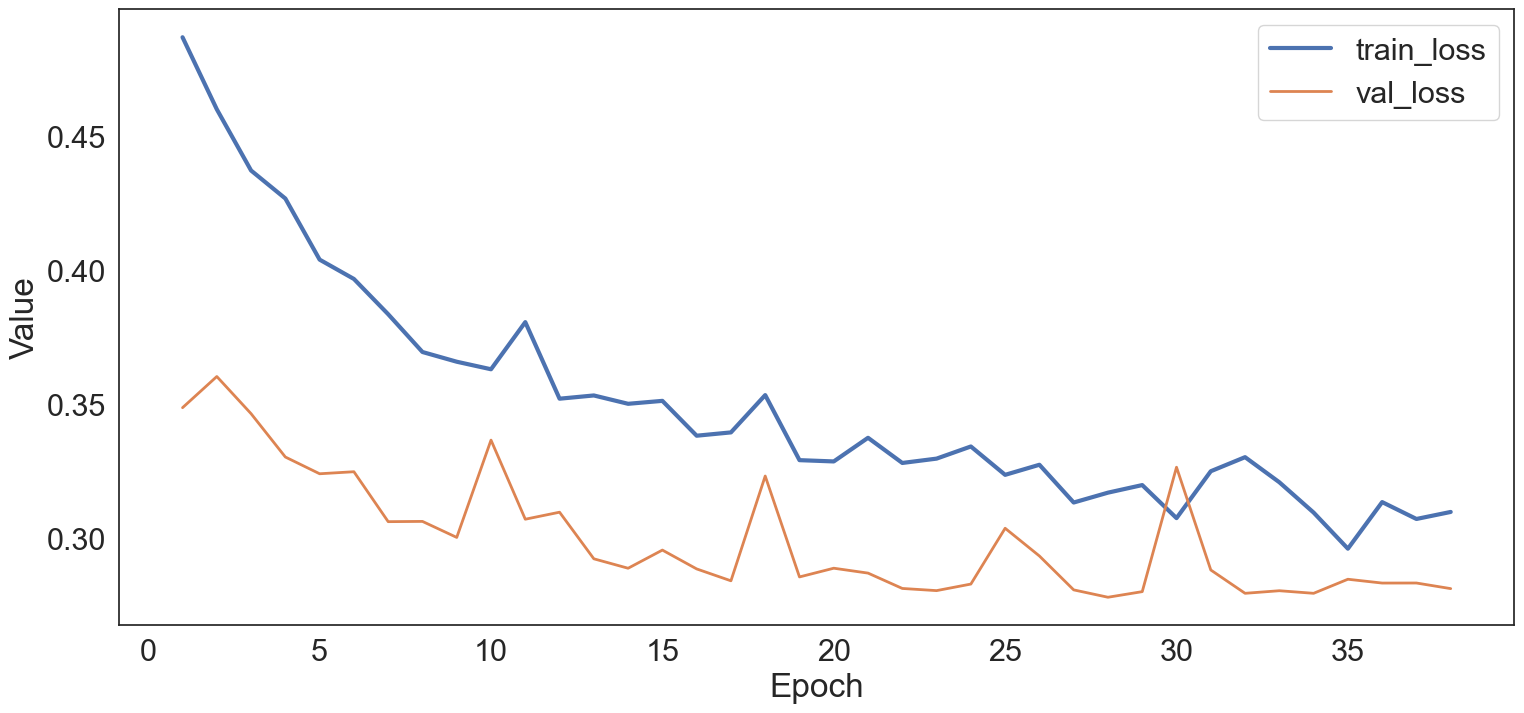

In [95]:
score = qc_tuning_model.evaluate(X_test, y_test, verbose=0)
print("tuning")
print(f"Test loss: {score[0] * 100:.2f}%")
print(f"Test accuracy: {score[1] * 100:.2f}%")

test_loss, test_accuracy = qc_manual_model.evaluate(X_test, y_test, verbose=0)
print("manual")
print(f'Test loss: {test_loss * 100:.2f}%')
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 8))
sns.set(font_scale=2)
sns.set_style("white")

plt.plot(range(1, len(train_loss) + 1), train_loss, label='train_loss', linewidth=3.0)
plt.plot(range(1, len(val_loss) + 1), val_loss, label='val_loss', linewidth=2.0)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [98]:
qc_manual_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 2986, 128)      │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,373 (228.02 KB)

 Trainable params: 19,457 (76.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,916 (152.02 KB)

# Load model predict quality of dataset and manual validation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
File: s0322-07052204_31_p_signal.txt, Prediction: [[0.0792927]] 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
File: s0322-07052204_54_p_signal.txt, Prediction: [[0.16438815]] 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: s0322-07052204_22_p_signal.txt, Prediction: [[0.04519744]] 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: s0402-08010704_64_p_signal.txt, Prediction: [[0.9642706]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
File: s0402-08010704_24_p_signal.txt, Prediction: [[0.93792975]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
File: s0402-08010704_98_p_signal.txt, Prediction: [[0.9574617]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: s0402-08010704_79_p_signal.txt, Prediction: [[0.9644489]] --> QUALITY SEGMENT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: s0322-07052204_21_p_signal.txt, Prediction: [[0.14900844]] 
s0322-07052204_31_p_signal.txt
s0322-07052204_54_p_signal.txt
s0322-07052204_22_p_signal.txt
s04

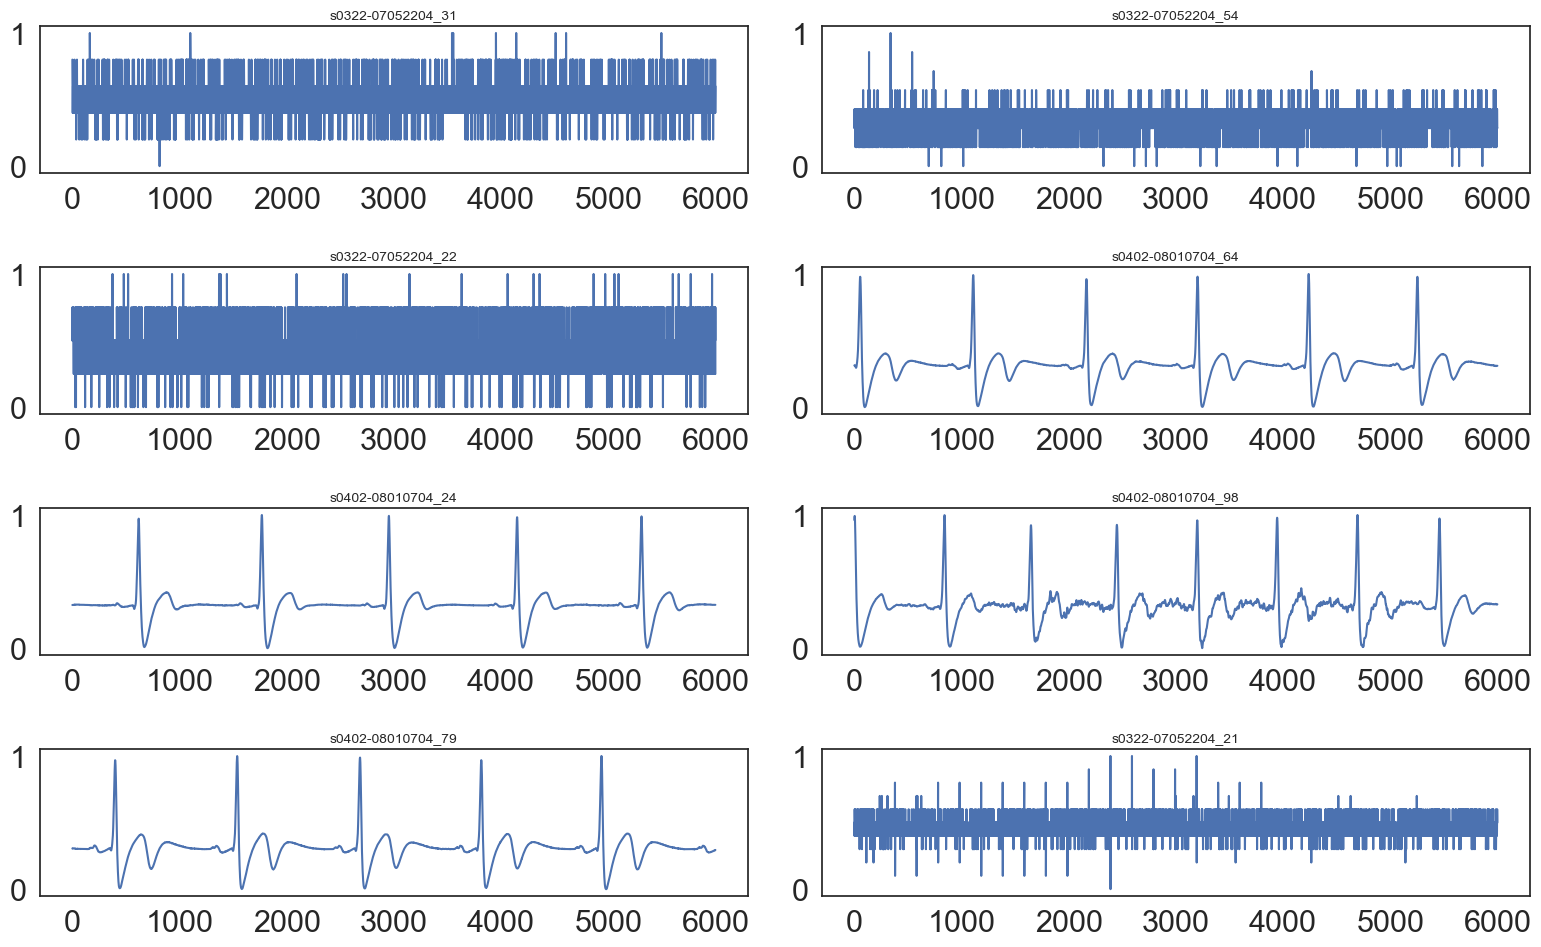

[0.37929537892341614, 0.8500000238418579]
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Train MSE: 0.09333550066537687
Test MSE: 0.10617198130496504
____________________
Train MAE: 0.17852468590809248
Test MAE: 0.1978423552121967
____________________
Train MAPE: 481468902619606.75
Test MAPE: 536271647250841.6
____________________
Train RMSE: 0.3055085934394921
Test RMSE: 0.3258404230677419
____________________
Train RMSPE: [1.29592748e+15]
Test RMSPE: [1.35814651e+15]


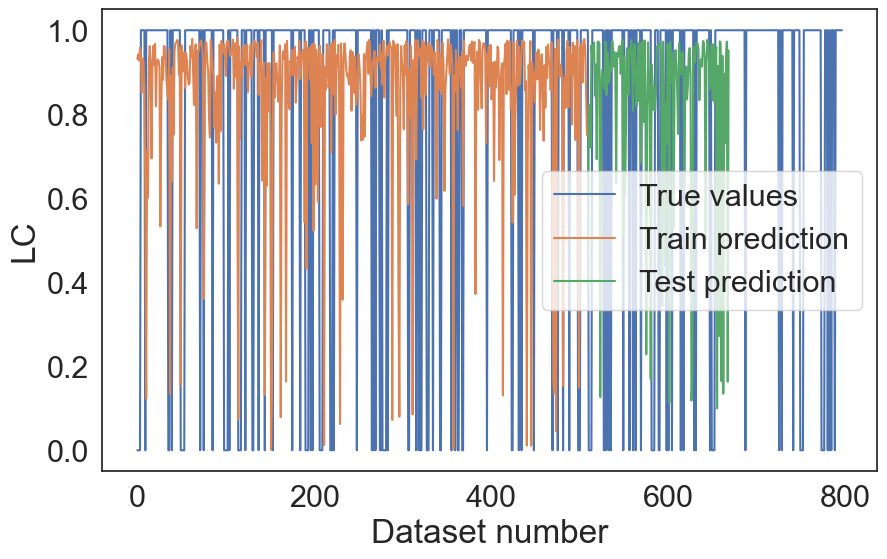

In [99]:
loaded_model = load_model(os.path.join(MODEL, FOLDER_QC_MODEL + "qc_model.keras"))

label_after_qc= os.path.join(FOLDER_FILTER, "label.txt")

for file_name in os.listdir(DATASET_QC_TEST):
    if file_name.endswith('signal.txt'):
        file_path = os.path.join(DATASET_QC_TEST, file_name)
        with open(file_path, 'r') as signal_file:
            signal = np.loadtxt(signal_file)
            prediction = loaded_model.predict(np.expand_dims(signal, axis=0))  
            quality_label = "--> QUALITY SEGMENT" if prediction > 0.5 else ""
            print(f"File: {file_name}, Prediction: {prediction} {quality_label}")
    
grid_plot(DATASET_QC_TEST, 1, 8, 2)

score = model.evaluate(X_test, y_test, batch_size=20, verbose=0)
print(score)

train_predict = loaded_model.predict(X_train)
test_predict = loaded_model.predict(X_test)

# Assuming scaler was used for normalization
scaler = MinMaxScaler()
scaler.fit(y.reshape(-1, 1))  # Fit on the original data labels

# Inverse transform predictions and true values
train_predict = scaler.inverse_transform(train_predict)
train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
train_mae = mean_absolute_error(train_true, train_predict)
test_mae = mean_absolute_error(test_true, test_predict)
train_mape = mean_absolute_percentage_error(train_true, train_predict)
test_mape = mean_absolute_percentage_error(test_true, test_predict)
train_mse = mean_squared_error(train_true, train_predict)
test_mse = mean_squared_error(test_true, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Avoid division by zero for RMSPE calculation
epsilon = np.finfo(float).eps
train_true_safe = np.where(train_true == 0, epsilon, train_true)
test_true_safe = np.where(test_true == 0, epsilon, test_true)
train_rmspe = np.sqrt(np.mean(np.square((train_true - train_predict) / train_true_safe), axis=0))
test_rmspe = np.sqrt(np.mean(np.square((test_true - test_predict) / test_true_safe), axis=0))

# Print error metrics
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print("____________________")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print("____________________")
print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")
print("____________________")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print("____________________")
print(f"Train RMSPE: {train_rmspe}")
print(f"Test RMSPE: {test_rmspe}")

# Prepare data for plotting
train_predict_plot = np.empty_like(y, dtype=np.float32).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(y, dtype=np.float32).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict):len(train_predict) + len(test_predict), :] = test_predict

true_values = y.reshape(-1, 1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.xlabel("Dataset number")
plt.ylabel("LC")
plt.plot(true_values, label="True values")
plt.plot(train_predict_plot, label="Train prediction")
plt.plot(test_predict_plot, label="Test prediction")
plt.legend()
plt.show()

# Predict all rest dataset in FOLDER_FILTER

In [16]:
loaded_model = load_model(os.path.join(MODEL, "qc_model.keras"))

with open(label_after_qc, 'w') as label_file:
    for file_name in os.listdir(FOLDER_FILTER):
        file_path = os.path.join(FOLDER_FILTER, file_name)
        
        if file_name.endswith('p_signal.txt'):
            with open(file_path, 'r') as signal_file:
                signal = np.loadtxt(signal_file)
                prediction = loaded_model.predict(np.expand_dims(signal, axis=0))
                label_file.write(f"{file_name} {prediction}\n")

print("Predictions complete and written to label.txt.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━

# Copy all qualified datasets to QUALITY_DATASET

In [19]:
folders = {
    True: DATASET_STROKE,
    False: DATASET_STROKE_UNQUALITY
}

with open(label_after_qc, 'r') as label_file:
    for line in label_file:
        file_name, label = line.strip().split()
        label = float(label.strip('[]'))
        
        source_file_path = os.path.join(FOLDER_FILTER, file_name)
        destination_folder = folders[label > 0.5]
        destination_file_path = os.path.join(destination_folder, file_name)
        
        shutil.copy2(source_file_path, destination_file_path)

print("Qualified segments have been moved to equivalent folder!")

Qualified segments have been moved to equivalent folder!


# Write label file from subject.xlsx

In [100]:
label_file = os.path.join(DATASET_STROKE, LABEL_FILE)
label_file_unquality = os.path.join(DATASET_STROKE_UNQUALITY, LABEL_FILE)

In [26]:

def write_labels(dataset_path, label_file_path, metadata):
    with open(label_file_path, 'w') as f:
        for file_name in os.listdir(dataset_path):
            if file_name.endswith('_signal.txt'):
                patient_code = file_name.split('-')[0].upper()
                patient_data = metadata[metadata['subject_number'].str.upper() == patient_code]
                if not patient_data.empty:
                    patient_info = patient_data.iloc[0]
                    label_info = [
                        patient_info['GROUP'],
                        patient_info['GROUP_TYPE'],
                        patient_info['Classification'],
                        patient_info['STROKE PATIENT MEDICAL HISTORY'],
                        patient_info['STROKE YR PATIENT MEDICAL HISTORY'],
                        patient_info['NIHSS'],
                        patient_info['MRS'],
                        patient_info['STROKE GROUP'],
                        patient_info['STROKE SIDE'],
                        patient_info['STROKE ETIOLOGY']
                    ]
                    f.write(f"{file_name} {' '.join(map(str, label_info))}\n")
                else:
                    print(file_name)
                    
label_file = os.path.join(DATASET_STROKE, LABEL_FILE)
label_file_unquality = os.path.join(DATASET_STROKE_UNQUALITY, LABEL_FILE)

metadata = pd.read_excel('subjects.xlsx', sheet_name='subjects')
write_labels(DATASET_STROKE, label_file, metadata)
print("_________________")
write_labels(DATASET_STROKE_UNQUALITY, label_file_unquality, metadata)

print("Label files created successfully.")

s0268-06060109_44_p_signal.txt
s0268-06060109_11_p_signal.txt
s0268-06060109_43_p_signal.txt
s0268-06060109_16_p_signal.txt
s0268-06060109_8_p_signal.txt
s0268-06060109_56_p_signal.txt
s0268-06060109_51_p_signal.txt
s0268-06060109_67_p_signal.txt
s0268-06060109_32_p_signal.txt
s0268-06060109_98_p_signal.txt
s0268-06060109_60_p_signal.txt
s0268-06060109_35_p_signal.txt
s0268-06060109_75_p_signal.txt
s0268-06060109_20_p_signal.txt
s0268-06060109_72_p_signal.txt
s0268-06060109_27_p_signal.txt
s0268-06060109_50_p_signal.txt
s0268-06060109_57_p_signal.txt
s0268-06060109_17_p_signal.txt
s0268-06060109_10_p_signal.txt
s0268-06060109_45_p_signal.txt
s0268-06060109_9_p_signal.txt
s0268-06060109_26_p_signal.txt
s0268-06060109_73_p_signal.txt
s0268-06060109_21_p_signal.txt
s0268-06060109_74_p_signal.txt
s0268-06060109_100_p_signal.txt
s0268-06060109_34_p_signal.txt
s0268-06060109_61_p_signal.txt
s0268-06060109_99_p_signal.txt
s0268-06060109_33_p_signal.txt
s0268-06060109_66_p_signal.txt
s0268-060

# Building Stroke Model

In [14]:
input_dim = (6000, 5)

def load_data(data_folder, label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            filename = parts[0]
            label = list(map(float, parts[1:]))
            labels[filename] = label
    
    signals = []
    signal_labels = []
    for filename in os.listdir(data_folder):
        if filename.endswith('_signal.txt'):
            file_path = os.path.join(data_folder, filename)
            signal = np.loadtxt(file_path).reshape(input_dim)
            if filename in labels:
                signals.append(signal)
                signal_labels.append(labels[filename])
    
    return np.array(signals), np.array(signal_labels)

label_file = os.path.join(DATASET_STROKE, LABEL_FILE)
X, y = load_data(DATASET_STROKE, label_file)

In [17]:
print(X.shape, y.shape)
for i in range(10):
    print(X[0][i], y[i])

(16619, 6000, 5) (16619, 10)
[ 3.69290573e-02  4.11215188e-02 -4.19246147e-03  5.25394991e-05
  3.10499791e-07] [ 0.  0.  0.  0. -1. -1. -1.  0. -1. -1.]
[ 2.91545190e-02  4.16469138e-02 -1.24923948e-02  5.56444970e-05
  4.74214794e-07] [ 0. -1.  0.  0. -1. -1. -1.  0. -1. -1.]
[ 2.52672498e-02  4.22344087e-02 -1.69671590e-02  6.20237950e-05
  6.53971971e-07] [ 0. -1.  0.  0. -1. -1. -1.  0. -1. -1.]
[ 2.42954325e-02  4.28873897e-02 -1.85919572e-02  6.87239364e-05
  6.84156079e-07] [1. 2. 1. 1. 1. 7. 1. 1. 2. 2.]
[ 2.52672498e-02  4.36088875e-02 -1.83416377e-02  7.57069166e-05
  7.10384661e-07] [ 1.  1.  1.  1. 13.  0.  0.  1.  1. 10.]
[ 2.62390671e-02  4.44015280e-02 -1.81624610e-02  8.29316296e-05
  7.32478487e-07] [ 1.  2.  1.  1.  6.  1.  0.  1.  2. 23.]
[ 2.72108844e-02  4.52675201e-02 -1.80566357e-02  9.03564863e-05
  7.50439954e-07] [ 0. -1.  0.  0. -1. -1. -1.  0. -1. -1.]
[ 2.91545190e-02  4.62086578e-02 -1.70541388e-02  9.79404287e-05
  7.64338057e-07] [ 0.  0.  0.  0. -1. -1

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
checkpoint_path = os.path.join(MODEL, "stroke_checkpoint.keras")
model_path = os.path.join(MODEL, "stroke_model.keras")

if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

if os.path.exists(model_path):
    os.remove(model_path)
    
kernel_size = 50
stride = 8
input_dim = (6000, 5)
num_filters_first_layer = 16
num_filters_second_layer = 32
num_filters_third_layer = 64
dropout_rate = 0.3
learning_rate = 0.0001
epochs = 50
batch_size = 32

def build_stroke_model():
    model = Sequential()
    
    model.add(LayerNormalization(input_shape=input_dim))
    model.add(Conv1D(filters=num_filters_first_layer, kernel_size=kernel_size, strides=stride, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=num_filters_second_layer, kernel_size=kernel_size, strides=stride, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=num_filters_third_layer, kernel_size=kernel_size, strides=stride, activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(10, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    return model

model = build_stroke_model()

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    # verbose=1 -> =====
    # verbose=2 -> Epoch 1/10

callbacks = [model_checkpoint, early_stopping, reduce_lr]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)

model.save(model_path)

/Users/macad/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - binary_accuracy: 0.2638 - loss: -1553.3806

KeyboardInterrupt: 